In [13]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [22]:
file_path = '../Features/Large/selected_features_CorrVar.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,RingCount,MolLogP,fr_C_O,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_amide,fr_aniline,fr_ether,fr_halogen
0,0,0.545511,0.223433,0.490223,0.390551,0.291325,0.250000,0.472316,0.592036,-1.017995,...,0.447214,0.451534,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
1,1,0.591920,0.253125,0.601726,0.389406,0.277681,0.278846,0.315886,0.215424,1.052267,...,0.447214,0.416318,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
2,1,0.553126,0.334919,0.502072,0.400859,0.399452,0.278846,0.472195,0.592036,-1.018511,...,0.447214,0.475805,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
3,0,0.612445,0.602032,0.496240,0.408749,0.461148,0.423077,0.676377,0.290413,0.491735,...,0.000000,0.560347,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
4,0,0.618170,0.914475,0.141109,0.000000,0.000000,0.000000,0.354992,0.378416,-0.071536,...,0.000000,0.225586,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [23]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [25]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 2113 samples
Test set: 374 samples


In [26]:
def objective(trial):
    # Define hyperparameter search space
    param = {
        "C": trial.suggest_float("C", 0.01, 10.0, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "gamma": trial.suggest_float("gamma", 1e-4, 1.0, log=True),
    }
    
    # Set up cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = SVC(**param, probability=True)  # Enable probability for ROC curve later
        model.fit(X_train_cv, y_train_cv)
        
        # Compute validation accuracy
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    # Return mean validation accuracy
    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

[I 2025-03-09 16:04:28,842] A new study created in memory with name: no-name-f5ad9639-34db-4c31-b267-4b49c39090bd


[I 2025-03-09 16:04:34,919] Trial 0 finished with value: 0.693327955362845 and parameters: {'C': 0.0629863643342251, 'kernel': 'poly', 'gamma': 0.5069393566441003}. Best is trial 0 with value: 0.693327955362845.
[I 2025-03-09 16:04:39,342] Trial 1 finished with value: 0.6956886603251431 and parameters: {'C': 8.786925877955051, 'kernel': 'sigmoid', 'gamma': 0.0009844442040465805}. Best is trial 1 with value: 0.6956886603251431.
[I 2025-03-09 16:04:43,619] Trial 2 finished with value: 0.708471423929728 and parameters: {'C': 1.1099309515173417, 'kernel': 'poly', 'gamma': 0.09637086105910031}. Best is trial 2 with value: 0.708471423929728.
[I 2025-03-09 16:04:50,369] Trial 3 finished with value: 0.5153809955967866 and parameters: {'C': 0.011862056745899303, 'kernel': 'sigmoid', 'gamma': 0.017688559079908787}. Best is trial 2 with value: 0.708471423929728.
[I 2025-03-09 16:04:56,186] Trial 4 finished with value: 0.6961603531533954 and parameters: {'C': 0.7275087588168019, 'kernel': 'sigmoid

Best trial: {'C': 1.2145459544209167, 'kernel': 'rbf', 'gamma': 0.270461251698111}


Final Model Accuracy on Test: 0.8539325842696629


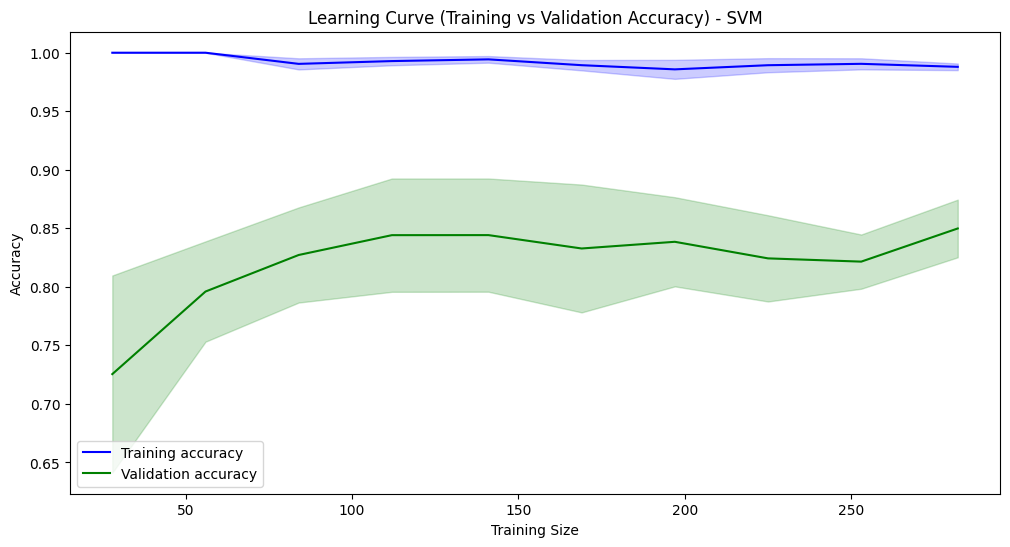

Train Accuracy: 0.9886685552407932
Test Accuracy: 0.8539325842696629


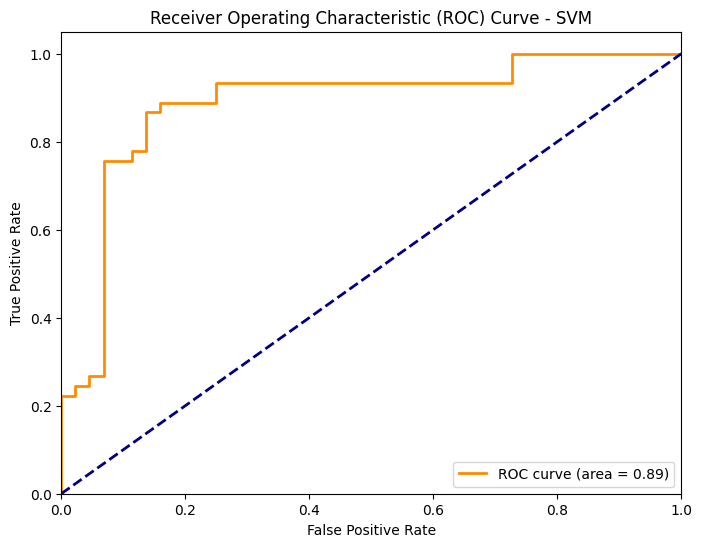

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

# Get best hyperparameters from study
best_params = study.best_trial.params

# Initialize the KNN model with best parameters
final_model = SVC(**best_params, probability=True)

# Fit the model on the training data
final_model.fit(X_train, y_train)

# Evaluate final model on test data
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy on Test:", accuracy_score(y_test, y_pred_final))

# Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy) - SVM')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# ROC Curve
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc='lower right')
plt.show()


In [7]:
import joblib

# Assuming 'model' is your trained QSAR model
joblib.dump(final_model, 'svm_model.pkl')

print("Model saved successfully!")


Model saved successfully!
